In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import keras
import os, glob
import sys

sys.path.append('..')
from utilities import downsample_series

In [4]:
%matplotlib inline

In [5]:
!ls

step4a_test_prediction_1D.ipynb  test_on_real_data_2D.ipynb
test_on_real_data_1D.ipynb


In [6]:
def ml_denoise(waveform_dir, file_name, t_shift):
    with h5py.File(waveform_dir + "/" + file_name, "r") as f:
        time = f["time"][:]
        waveform_BH1 = f["waveforms/BH1"][:]
        waveform_BH2 = f["waveforms/BH2"][:]
        waveform_BHZ = f["waveforms/BHZ"][:]

    # down-sample the data to the same sampling rate with the trained model
    f_downsample = 1
    _, waveform_BH1, _ = downsample_series(time=time, series=waveform_BH1, f_downsampe=f_downsample)
    _, waveform_BH2, _ = downsample_series(time=time, series=waveform_BH2, f_downsampe=f_downsample)
    time, waveform_BHZ, dt = downsample_series(time=time, series=waveform_BHZ, f_downsampe=f_downsample)

    waveforms = np.array([waveform_BH1, waveform_BH2, waveform_BHZ])
    waveforms_all = waveforms.copy()

    # get the 10-minutes long data
    time_new = np.arange(0, 600) + t_shift
    waveforms = waveforms[:, time_new]

    # scale the waveforms with the mean and std
    traces_mean = np.reshape(np.mean(waveforms, axis=1), (3, 1))
    traces_std = np.reshape(np.std(waveforms, axis=1), (3, 1))

    waveforms_new = waveforms.copy()
    waveforms_new = (waveforms_new - traces_mean) / traces_std

    waveforms_new = np.moveaxis(waveforms_new, 0, -1)
    waveforms_new = waveforms_new.reshape(-1, waveforms_new.shape[0], waveforms_new.shape[1])

    # denoise the waveforms
    Y_predict = model.predict(waveforms_new)

    waveforms_new = np.squeeze(waveforms_new).T * traces_std
    waveforms_predicted = np.squeeze(Y_predict).T * traces_std  # + traces_mean

    return time_new, waveforms_new, waveforms_predicted, waveforms_all

In [7]:
# %% Need to specify model_name first
model_path = '../Model_and_datasets_1D'
model_name = 'AE_ENZ_LeakyReLU_skip_connection'

# %% load model
model = keras.models.load_model(model_path + f'/{model_name}' + f'/{model_name}_Model.hdf5')

# %% make a directory to hold the realistic waveform results
output_dir = model_path + f'/{model_name}' + '/real_waveforms'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)


OSError: SavedModel file does not exist at: ../Model_and_datasets_1D/AE_ENZ_LeakyReLU_skip_connection/AE_ENZ_LeakyReLU_skip_connection_Model.hdf5/{saved_model.pbtxt|saved_model.pb}

In [27]:
# load the waveforms
waveform_dir = "../waveforms/events_data_processed"
waveform_files = np.array(os.listdir(waveform_dir))

In [28]:
waveform_files

array(['IU.XMAS.M6.5.20210401-095637.hdf5',
       'IU.XMAS.M6.4.20190306-154614.hdf5',
       'IU.XMAS.M7.0.20210121-122304.hdf5',
       'IU.XMAS.M6.4.20200109-083808.hdf5',
       'IU.XMAS.M6.4.20191016-113705.hdf5',
       'IU.XMAS.M7.8.20200722-061244.hdf5',
       'IU.XMAS.M6.0.20191114-211254.hdf5',
       'IU.XMAS.M6.1.20200128-215516.hdf5',
       'IU.XMAS.M6.1.20200126-063155.hdf5',
       'IU.XMAS.M6.1.20190422-091111.hdf5',
       'IU.XMAS.M6.0.20200416-080437.hdf5',
       'IU.XMAS.M6.3.20200127-050201.hdf5',
       'IU.XMAS.M8.1.20210304-192833.hdf5',
       'IU.XMAS.M6.0.20191224-190352.hdf5',
       'IU.XMAS.M6.3.20191120-042705.hdf5',
       'IU.XMAS.M6.3.20190519-012329.hdf5',
       'IU.XMAS.M6.0.20200129-134949.hdf5',
       'IU.XMAS.M6.1.20200722-061618.hdf5',
       'IU.XMAS.M6.1.20210304-231300.hdf5',
       'IU.XMAS.M6.2.20200123-055302.hdf5',
       'IU.XMAS.M6.7.20210203-052343.hdf5',
       'IU.XMAS.M6.0.20200118-163814.hdf5',
       'IU.XMAS.M6.6.20200818-00

(-2000.0, 2000.0)

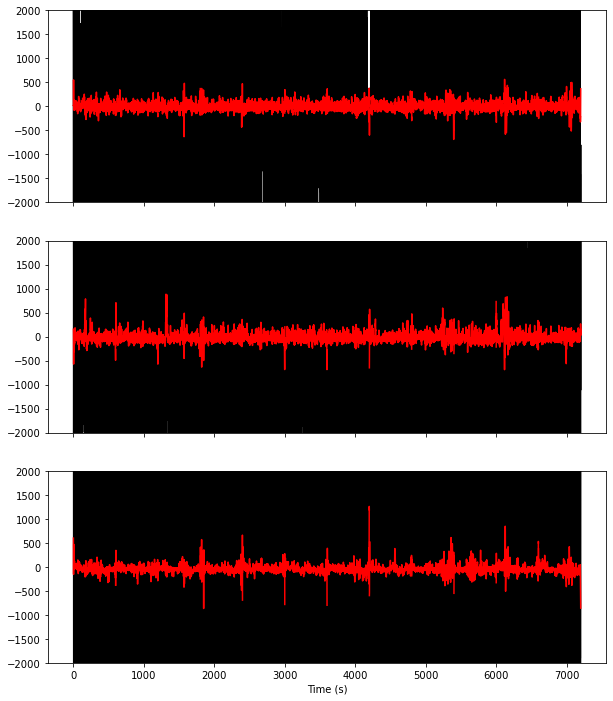

In [31]:
file_name = "IU.XMAS.M6.0.20191224-190352.hdf5"
step = 600
plt.close('all')
_, ax = plt.subplots(3, 1, sharex=True, sharey=True, num=1, figsize=(10, 12))
for t_shift in np.arange(0, 6900, step):
    time_new, waveforms, waveforms_predicted, _ = ml_denoise(waveform_dir=waveform_dir, file_name=file_name,
                                                             t_shift=t_shift)
    for i, axi in enumerate(ax):
        axi.plot(time_new, waveforms[i, :], '-k', zorder=1)
        axi.plot(time_new, waveforms_predicted[i, :], '-r', zorder=10)
    if i == 2:
        axi.set_xlabel('Time (s)')

axi.set_ylim(-2e3, 2e3)
#axi.set_xlim(4000, 5000)